## Assignment Week 5 - Biswajit Sharma

Get the stemmed data using the same process you did in Week 3.

In [58]:
# import modules

import pandas as pd
import unicodedata
import sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# read the dataset into a dataframe
df = pd.read_csv("./datasets/labeledTrainData.tsv", sep="\t")

In [3]:
# convert reviews to lower case and store in a new column
df["cleaned_review"] = df["review"].str.lower()

In [4]:
# this function clean punctuation and symbols from input text
punctuation = dict.fromkeys(
[i for i in range(sys.maxunicode)
if unicodedata.category(chr(i)).startswith("P") or unicodedata.category(chr(i)).startswith("S")],
    None
 )
def remove_punctuation_symbols(text):
    return text.translate(punctuation)

In [5]:
# remove punctuation and symbols from reviews using the above function 
df["cleaned_review"] = df["cleaned_review"].apply(remove_punctuation_symbols)

In [6]:
# this function removes stopwords from input text
stop_words = stopwords.words("english")
def remove_stopwords(text):
    tokenized_words = word_tokenize(text)
    return " ".join([word for word in tokenized_words if word not in stop_words])

In [7]:
# remove stopwords from reviews using above function
df["cleaned_review"] = df["cleaned_review"].apply(remove_stopwords)

In [8]:
# this function perform stemming on the input text using NLTK PorterStemmer
def porter_stemmer(text):
    tokenized_words = word_tokenize(text)
    porter = PorterStemmer()
    return " ".join([porter.stem(words) for words in tokenized_words])

In [9]:
# apply stemming on reviews using above function
df["cleaned_review"] = df["cleaned_review"].apply(porter_stemmer)

In [10]:
# view few rows after the above text preparation
df.head()

,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothi hine entertain film ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film start manag nichola bell give welcom inve...
3,3630_4,0,It must be assumed that those who praised this...,must assum prais film greatest film opera ever...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti 80 exploit ...


Split this into a training and test set.

In [11]:
#features and target names
features_columns = "cleaned_review"
target_column = "sentiment"

In [12]:
# using sklearn's train_test_split method to split the dataset
features_train, features_test, target_train, target_test = train_test_split(
    df[features_columns], df[target_column], test_size=0.2, random_state=0
)

Fit and apply the tf-idf vectorization to the training set.

In [13]:
# generate term frequency-inverse document frequency (tf-idf) matrix using TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(features_train)

TfidfVectorizer()

In [14]:
# apply Tf-Idf to ONLY train set
tfidf_train_feature_matrix = tfidf.transform(features_train)

In [15]:
tfidf_train_feature_matrix

<20000x81126 sparse matrix of type '<class 'numpy.float64'>'
	with 1956541 stored elements in Compressed Sparse Row format>

Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

We must **not** fit the tf-idf vectorization to the test set, so that the test data remains as totally unseen data during fitting process and there is no chance of test data leak or sneak while fitting. This is the reason we must always fit any preprocessing on the _training_ set not _test set_. 

In [16]:
# apply Tf-Idf to test set
tfidf_test_feature_matrix = tfidf.transform(features_test)

Train a logistic regression using the training data.

In [17]:
logistic = LogisticRegression(random_state=0)

In [18]:
logistic_model = logistic.fit(tfidf_train_feature_matrix, target_train)

Find the model accuracy on test set.

In [19]:
# predict the target from fitted logistic reression model for both train and test set
predicted_target_train = logistic_model.predict(tfidf_train_feature_matrix)
predicted_target_test = logistic_model.predict(tfidf_test_feature_matrix)

In [20]:
# get the accuracy score of the logistic regression model on test set
accuracy_score(target_test, predicted_target_test)

0.8926

Create a confusion matrix for the test set predictions.

In [24]:
# create confusion matrix for the test using using sklearn's confusion_matrix module
matrix = confusion_matrix(target_test, predicted_target_test, labels=logistic_model.classes_)

In [25]:
#print the confusion matrix
print(matrix)

[[2240  308]
 [ 229 2223]]


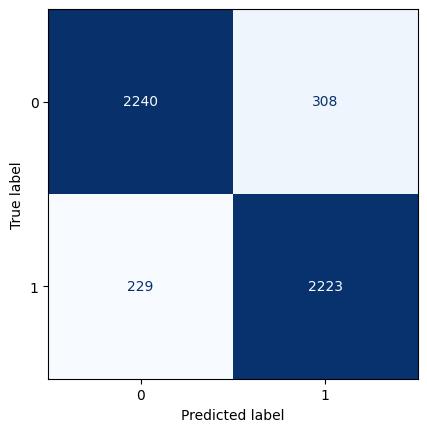

In [69]:
# plot confusion matrix using sklearn's ConfusionMatrixDisplay module
ConfusionMatrixDisplay.from_predictions(target_test, predicted_target_test, 
                                        display_labels=logistic_model.classes_,
                                        colorbar=False, 
                                        cmap="Blues")
plt.show()

Get the precision, recall, and F1-score for the test set predictions.

In [31]:
print(f"Precision: {precision_score(target_test, predicted_target_test)}")
print(f"Recall: {recall_score(target_test, predicted_target_test)}")
print(f"F1-Score: {f1_score(target_test, predicted_target_test)}")

Precision: 0.8783089687870407
Recall: 0.9066068515497553
F1-Score: 0.8922335942203492


In [41]:
#get target probabilities
target_probabilities = logistic.predict_proba(tfidf_test_feature_matrix)[:,1]

In [42]:
#calculate true and false positive rates for test set
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)


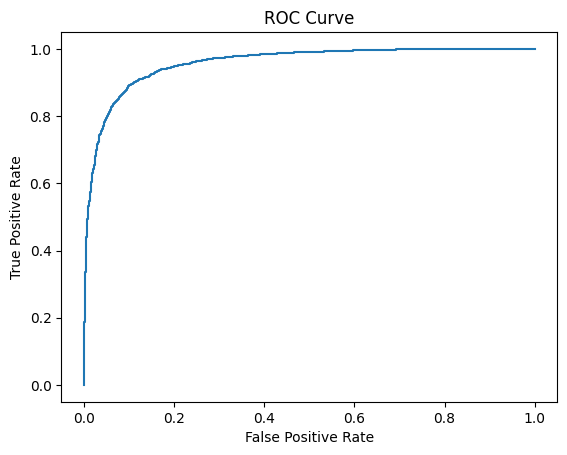

In [44]:
# plotting the ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [61]:
print(f"Area Under ROC Curve: {roc_auc_score(target_test, predicted_target_test)}")

Area Under ROC Curve: 0.8928638653353171


Pick another classification model you learned about this week and repeat steps (5) – (9).

In [46]:
# import KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [47]:
# create a K-nearest Neighbor classifier
knn = KNeighborsClassifier(n_neighbors=10)

In [48]:
# as we are not aware of appropriate K-value or number of K neigbors, lets perform a gridsearch to identfy suitable K value
hyperparameters = {
    "n_neighbors":[10, 50, 70, 80, 100]
}

In [49]:
# create gridsearch
gcv = GridSearchCV(
    knn,
    hyperparameters,
    cv=3,
    verbose=1
)

In [50]:
# perform grid serach
best_model = gcv.fit(tfidf_train_feature_matrix, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [51]:
# check best k value
print(best_model.best_estimator_)

KNeighborsClassifier(n_neighbors=80)


we see that the best model is fitted for 80 neigbors(k)

In [52]:
# using the best model generated from grid search in predition of target
knn_predicted_target_test = best_model.predict(tfidf_test_feature_matrix)

In [65]:
# create confusion matrix for the test using using sklearn's confusion_matrix module
knn_matrix = confusion_matrix(target_test, knn_predicted_target_test, labels=best_model.classes_)

In [66]:
#print the confusion matrix
print(knn_matrix)

[[2109  439]
 [ 432 2020]]


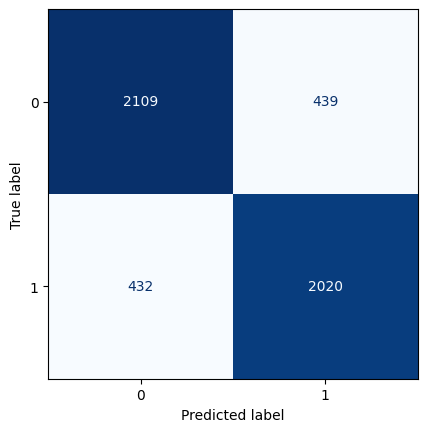

In [71]:
# plot confusion matrix using sklearn's ConfusionMatrixDisplay module
ConfusionMatrixDisplay.from_predictions(target_test, knn_predicted_target_test, 
                                        display_labels=best_model.classes_,
                                        colorbar=False,
                                        cmap="Blues")
plt.show()

In [54]:
#get target probabilities
knn_target_probabilities = best_model.predict_proba(tfidf_test_feature_matrix)[:,1]

In [55]:
#calculate true and false positive rates for test set
knn_fasle_positive_rate, knn_true_positive_rate, threshold = roc_curve(target_test, knn_target_probabilities)

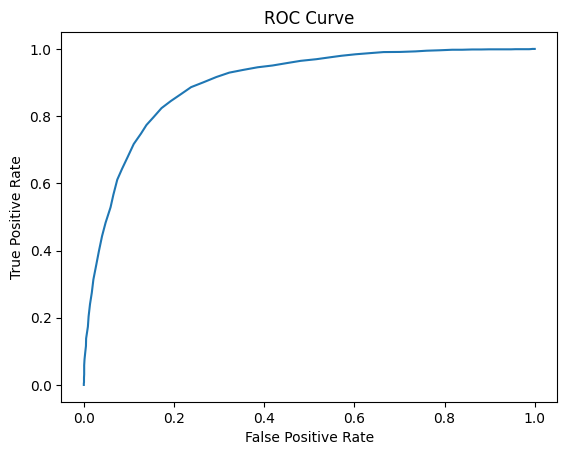

In [56]:
#plotting the ROC curve
plt.plot(knn_fasle_positive_rate, knn_true_positive_rate)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [62]:
print(f"Area Under ROC Curve: {roc_auc_score(target_test, knn_predicted_target_test)}")

Area Under ROC Curve: 0.82576264914298
